tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


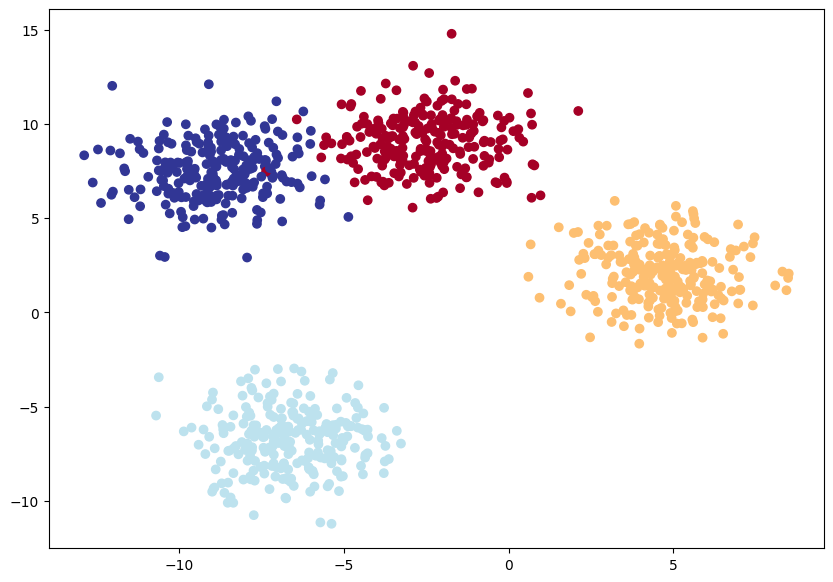

In [1]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [2]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_0 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_0

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [4]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(),
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

In [6]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_0(X_blob_train.to(device))[:5]

tensor([[ 0.0312, -0.0557, -0.4373,  0.1583],
        [ 1.3097, -0.1300,  1.0540,  1.3127],
        [ 0.0529,  0.1173, -0.4931,  0.2178],
        [ 0.2724,  0.0551, -0.2141,  0.4046],
        [ 1.1518, -0.0993,  0.8598,  1.1751]], grad_fn=<SliceBackward0>)

In [8]:
# How many elements in a single prediction sample?
model_0(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [9]:
# Make prediction logits with model
y_logits = model_0(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.1776, -0.0708, -0.2635,  0.2890],
        [ 1.5337, -0.0907,  1.2909,  1.5269],
        [-0.0332,  0.0999, -0.5831,  0.1349],
        [-0.0526, -0.0268, -0.5462,  0.0882],
        [ 1.1501, -0.1405,  0.8770,  1.1640]], grad_fn=<SliceBackward0>)
tensor([[0.2824, 0.2203, 0.1817, 0.3157],
        [0.3362, 0.0662, 0.2637, 0.3339],
        [0.2563, 0.2927, 0.1479, 0.3032],
        [0.2640, 0.2709, 0.1612, 0.3039],
        [0.3278, 0.0902, 0.2495, 0.3325]], grad_fn=<SliceBackward0>)


In [10]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [11]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.2824, 0.2203, 0.1817, 0.3157], grad_fn=<SelectBackward0>)
tensor(3)


In [12]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [13]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_0(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.34279, Acc: 19.25% | Test Loss: 0.66550, Test Acc: 69.50%
Epoch: 10 | Loss: 0.22114, Acc: 96.62% | Test Loss: 0.19521, Test Acc: 98.00%
Epoch: 20 | Loss: 0.10087, Acc: 99.00% | Test Loss: 0.09217, Test Acc: 99.00%
Epoch: 30 | Loss: 0.07000, Acc: 99.00% | Test Loss: 0.06270, Test Acc: 99.50%
Epoch: 40 | Loss: 0.05624, Acc: 99.00% | Test Loss: 0.04894, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04866, Acc: 99.00% | Test Loss: 0.04113, Test Acc: 99.50%
Epoch: 60 | Loss: 0.04393, Acc: 99.00% | Test Loss: 0.03615, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04072, Acc: 99.00% | Test Loss: 0.03271, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03843, Acc: 99.00% | Test Loss: 0.03019, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03671, Acc: 99.00% | Test Loss: 0.02828, Test Acc: 99.50%


In [14]:
# Make predictions
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  5.9111,  11.3536, -11.1477,  -6.5377],
        [  5.2901, -10.2556,   3.2240,  10.9976],
        [-11.3342, -17.1156,  18.1835,   9.4701],
        [  1.8088,   7.2989,  -5.9284,  -4.9688],
        [ 11.2042,   6.3893, -11.2865,  -0.1618],
        [  5.9607, -12.8152,   4.4553,  13.3961],
        [-11.6989, -14.2248,  16.5443,   6.9309],
        [  9.3468,   1.8911,  -7.2011,   2.7420],
        [-11.7325, -22.2716,  21.7709,  13.5461],
        [  9.8297,   3.4684,  -8.5270,   1.6511]])

In [15]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


In [16]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

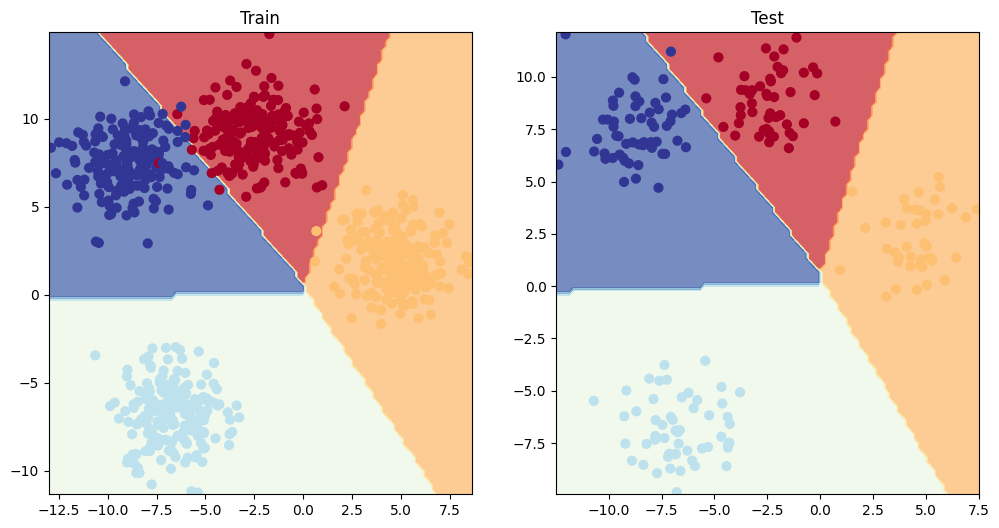

In [17]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_blob_test, y_blob_test)